In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf 
import numpy as np

tf.random.set_seed(0)

In [146]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step


In [0]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=500, padding='post')
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=500, padding='post')

In [0]:
class Word_Attention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super(Word_Attention, self).__init__(**kwargs)
    self.units = units
    self.w_w = tf.keras.layers.Dense(units)
    self.test_u = tf.keras.layers.Dense(1, 
                                        kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                        use_bias=False)

  def build(self, input_shape):
    self.u_w = self.add_weight(shape=(self.units, 1), 
                               trainable=True, 
                               name='u_w', 
                               initializer=tf.keras.initializers.GlorotNormal())

  def call(self, inputs):
    u_it_base = self.w_w(inputs)
    
    ait = tf.nn.softmax(self.test_u(u_it_base), axis=1)
    si = tf.reduce_sum(inputs * ait, axis=1)


    a_it = tf.matmul(u_it_base, self.u_w) # b, t, 1
    a_it = tf.squeeze(a_it, -1) # b, t
    a_it = tf.math.exp(a_it)
    a_it /= tf.cast(tf.reduce_sum(a_it, axis=1, keepdims=True) + tf.keras.backend.epsilon(), tf.float32)
    a_it = tf.expand_dims(a_it, -1)
    weighted_input = inputs * a_it
    output = tf.reduce_sum(weighted_input, axis=1)

    return output, si

In [0]:
input_ = tf.keras.layers.Input(shape=(500,))
emb = tf.keras.layers.Embedding(10000+1, 256)(input_)
x = tf.keras.layers.GRU(128, return_sequences=True)(emb)

att_layer = Word_Attention(128)
original, my_att = att_layer(x)

ga = tf.keras.layers.GlobalAvgPool1D()(x)
gm = tf.keras.layers.GlobalMaxPool1D()(x)
concat = tf.keras.layers.Concatenate()([ga, gm])

out_1 = tf.keras.layers.Dense(1, name='original_att')(original)
out_2 = tf.keras.layers.Dense(1, name='my_att')(my_att)
out_3 = tf.keras.layers.Dense(1, name='non_att')(concat)

model = tf.keras.models.Model(input_, [out_1, out_2, out_3])

In [0]:
model.compile(loss=['binary_crossentropy', 'binary_crossentropy', 'binary_crossentropy'], optimizer='adam', metrics=['acc', 'acc', 'acc'])

In [252]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_71 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_34 (Embedding)        (None, 500, 256)     2560256     input_71[0][0]                   
__________________________________________________________________________________________________
gru_34 (GRU)                    (None, 500, 128)     148224      embedding_34[0][0]               
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 128)          0           gru_34[0][0]                     
___________________________________________________________________________________________

In [253]:
hist = model.fit(x_train, [y_train, y_train, y_train], epochs=50, validation_data=(x_test, [y_test, y_test, y_test]), batch_size=256)

Train on 25000 samples, validate on 25000 samples
Epoch 1/50
25000/25000 [==============================] - 491s 20ms/sample - loss: 9.1005 - original_att_loss: 0.6714 - my_att_loss: 0.7142 - non_att_loss: 7.7109 - original_att_acc: 0.6358 - my_att_acc: 0.6170 - non_att_acc: 0.5000 - val_loss: 8.7374 - val_original_att_loss: 0.4620 - val_my_att_loss: 0.5636 - val_non_att_loss: 7.7131 - val_original_att_acc: 0.8250 - val_my_att_acc: 0.8238 - val_non_att_acc: 0.5000
Epoch 2/50
25000/25000 [==============================] - 481s 19ms/sample - loss: 8.5391 - original_att_loss: 0.4055 - my_att_loss: 0.4207 - non_att_loss: 7.7109 - original_att_acc: 0.8577 - my_att_acc: 0.8548 - non_att_acc: 0.5000 - val_loss: 8.5645 - val_original_att_loss: 0.4013 - val_my_att_loss: 0.4510 - val_non_att_loss: 7.7131 - val_original_att_acc: 0.8426 - val_my_att_acc: 0.7993 - val_non_att_acc: 0.5000
Epoch 3/50
25000/25000 [==============================] - 496s 20ms/sample - loss: 8.3006 - original_att_loss: 0

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
hist_df = pd.DataFrame(hist.history)

In [260]:
hist_df.head()

,loss,original_att_loss,my_att_loss,non_att_loss,original_att_acc,my_att_acc,non_att_acc,val_loss,val_original_att_loss,val_my_att_loss,val_non_att_loss,val_original_att_acc,val_my_att_acc,val_non_att_acc
0,9.100482,0.671445,0.714212,7.710865,0.63580,0.61704,0.50000,8.737377,0.462012,0.563556,7.713120,0.82496,0.82380,0.50000
1,8.539131,0.405496,0.420723,7.710865,0.85772,0.85476,0.50000,8.564494,0.401259,0.450951,7.713120,0.84260,0.79928,0.50000
2,8.300576,0.293159,0.294126,7.715049,0.90728,0.90400,0.50000,8.488217,0.371875,0.403513,7.713120,0.88024,0.87948,0.50000
3,2.626608,0.450961,0.374331,1.795560,0.87388,0.88132,0.72684,1.295725,0.517616,0.371385,0.405805,0.86976,0.87860,0.84028
4,0.791047,0.247468,0.270554,0.272206,0.93020,0.92860,0.91000,1.292161,0.437302,0.440748,0.413825,0.88168,0.88272,0.85824


In [0]:
plt.style.use('seaborn')

In [0]:
train_loss = hist_df.iloc[:, :4]
train_acc = hist_df.iloc[:, 4:7]

val_loss = hist_df.iloc[:, 7:11]
val_acc = hist_df.iloc[:, -3:]

In [294]:
hist_df.describe()

,loss,original_att_loss,my_att_loss,non_att_loss,original_att_acc,my_att_acc,non_att_acc,val_loss,val_original_att_loss,val_my_att_loss,val_non_att_loss,val_original_att_acc,val_my_att_acc,val_non_att_acc
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.830139,0.116682,0.123893,0.589452,0.969012,0.966185,0.944094,3.854364,1.264482,1.212782,1.376047,0.848475,0.847191,0.827639
std,2.052224,0.148887,0.159617,1.838796,0.060204,0.065155,0.122681,1.570846,0.442719,0.427975,1.641310,0.021076,0.024851,0.084778
min,0.045864,0.015384,0.015406,0.014912,0.635800,0.617040,0.500000,1.292161,0.371875,0.371385,0.405805,0.739400,0.736040,0.500000
25%,0.068913,0.021467,0.022837,0.024587,0.963180,0.961080,0.960840,3.029402,0.922477,0.820281,0.778541,0.846890,0.846450,0.847890
50%,0.152998,0.047421,0.045432,0.059383,0.995540,0.995640,0.990060,4.088094,1.444785,1.402512,1.080688,0.848480,0.848780,0.850160
75%,0.505501,0.160250,0.168182,0.158457,0.998280,0.998190,0.998050,4.358275,1.588072,1.516688,1.251599,0.854830,0.854590,0.854790
max,9.100482,0.671445,0.714212,7.715049,0.998960,0.998960,0.999000,8.737377,1.845891,1.739215,7.713120,0.881680,0.882720,0.862800


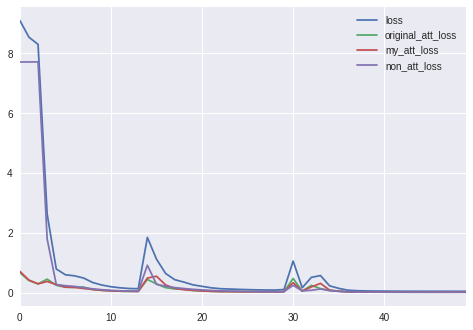

In [290]:
train_loss.plot()

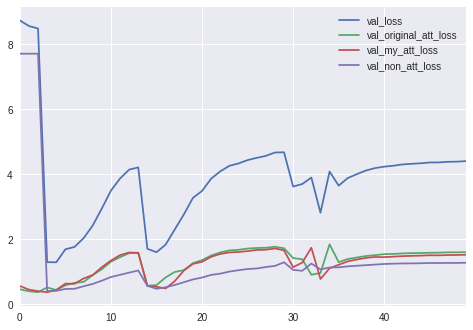

In [291]:
val_loss.plot()

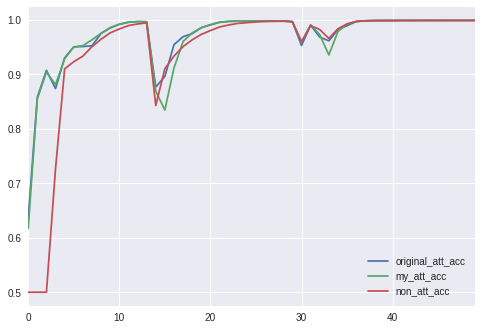

In [292]:
train_acc.plot()

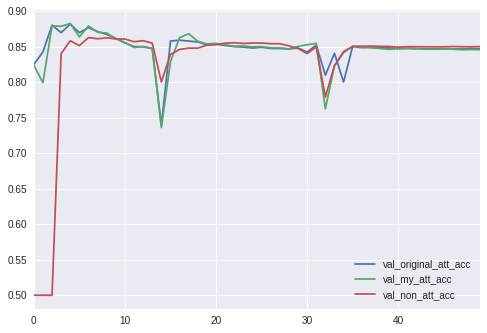

In [293]:
val_acc.plot()

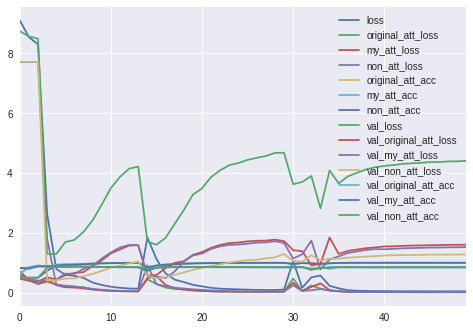

In [264]:
hist_df.plot()

Layer Checker

In [0]:
word_att = Word_Attention(10)

In [0]:
x = tf.random.normal(shape=(1, 20, 100))

In [0]:
test_input = tf.keras.Input(shape=(10, 100))

word_att(test_input)

In [189]:
word_att(x)

InvalidArgumentError: ignored

In [144]:
word_att.test_u.weights

[<tf.Variable 'word__attention_26/dense_36/kernel:0' shape=(10, 1) dtype=float32, numpy=
 array([[ 0.26000917],
        [-0.24140923],
        [ 0.59523344],
        [-0.8508912 ],
        [ 0.03657328],
        [-0.22005762],
        [-0.06470691],
        [-0.23102653],
        [ 0.02673758],
        [-0.6549997 ]], dtype=float32)>]

In [145]:
word_att.u_w

<tf.Variable 'word__attention_26/u_w:0' shape=(10, 1) dtype=float32, numpy=
array([[ 0.0135559 ],
       [ 0.65638024],
       [ 0.20669049],
       [ 0.23096614],
       [-0.22437137],
       [-0.19558033],
       [-0.4239753 ],
       [-0.30856693],
       [-0.33379233],
       [ 0.06748223]], dtype=float32)>